## Проект "Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

* качество предсказания;
* скорость предсказания;
* время обучения.

Основные шаги:
1) Загрузить данные, путь к файлу: /datasets/autos.csv.

2) Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.

3) Подготовить выборки для обучения моделей.

4) Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.

5) Проанализировать время обучения, время предсказания и качество моделей.

6) Опираясь на критерии заказчика, выберать лучшую модель, проверить её качество на тестовой выборке.

Примечания:
* Для оценки качества моделей применять метрику RMSE.
* Значение метрики RMSE должно быть меньше 2500.
* Самостоятельно освоить библиотеку LightGBM и её средствами постройть модели градиентного бустинга.
* Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдити её.
* Модель градиентного бустинга может долго обучаться, поэтому изменить у неё только два-три параметра.
* Если перестанет работать Jupyter Notebook, удалить лишние переменные оператором del.

Описание данных

Данные находятся в файле /datasets/autos.csv. 

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

In [1]:
#!pip install lightgbm # импортируем библиотеку lightgbm

In [2]:
#!pip install catboost # импортируем библиотеку catboost

In [3]:
!pip install category_encoders

     |████████████████████████████████| 81 kB 1.7 MB/s eta 0:00:01


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb 
import catboost as cb
import category_encoders as ca


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.preprocessing import OrdinalEncoder

In [5]:
try:
    df = pd.read_csv('C:\\Data\\autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [6]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [9]:
for column in df.columns:
    print(f'{column} : Число пропусков / пустых строк = {df[column].isna().sum()}')

DateCrawled : Число пропусков / пустых строк = 0
Price : Число пропусков / пустых строк = 0
VehicleType : Число пропусков / пустых строк = 37490
RegistrationYear : Число пропусков / пустых строк = 0
Gearbox : Число пропусков / пустых строк = 19833
Power : Число пропусков / пустых строк = 0
Model : Число пропусков / пустых строк = 19705
Kilometer : Число пропусков / пустых строк = 0
RegistrationMonth : Число пропусков / пустых строк = 0
FuelType : Число пропусков / пустых строк = 32895
Brand : Число пропусков / пустых строк = 0
Repaired : Число пропусков / пустых строк = 71154
DateCreated : Число пропусков / пустых строк = 0
NumberOfPictures : Число пропусков / пустых строк = 0
PostalCode : Число пропусков / пустых строк = 0
LastSeen : Число пропусков / пустых строк = 0


**Вывод** 
* Имеются пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `FuelType` и `Repaired`. 

* Некорректный тип данных в `DateCrawled`, `DateCreated` и `LastSeen`

* Имеется верхний регистр названий столбцов

## Предоработка данных

Для обучения модели выделим следующие признаки (столбцы): `VehicleType`, `RegistrationYear`, `Gearbox`, `Power`, `Model`, `Kilometer`, `RegistrationMonth`, `FuelType`, `Brand`, `Repaired`.

Целевым признаком, как уже было упомянуто будет `Price` — цена (евро).

In [10]:
df = df.rename(columns=str.lower) #Переводим названия стобцов в нижний регистр

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  repaired           283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [12]:
df['datecrawled'] = pd.to_datetime(df['datecrawled'], format='%Y-%m-%d %H:%M:%S') # Переведём столбцы с датами в форма дат
df['datecreated'] = pd.to_datetime(df['datecreated'], format='%Y-%m-%d %H:%M:%S')
df['lastseen'] = pd.to_datetime(df['lastseen'], format='%Y-%m-%d %H:%M:%S')

In [13]:
df.duplicated().sum()

4

In [14]:
df.drop_duplicates(inplace=True) # Уберём дубликаты, поскольку их не так много по сравнению с общей выборкой

In [15]:
df.duplicated().sum()

0

In [16]:
df['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

Мы видим, что в назаниях имеется значение `other`. Заполним им пропуски.

In [17]:
df['model'] = df['model'].fillna('other')

Посмотрим другие столбцы.

In [18]:
df['gearbox'].value_counts()

manual    268249
auto       66283
Name: gearbox, dtype: int64

Пропуски монжо заполнить `unknown`

In [19]:
df['gearbox'] = df['gearbox'].fillna('unknown')

In [20]:
df['repaired'].value_counts()

no     247158
yes     36053
Name: repaired, dtype: int64

Пропуски монжо заполнить `unknown`

In [21]:
df['repaired'] = df['repaired'].fillna('unknown')

In [22]:
df['fueltype'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fueltype, dtype: int64

In [23]:
df['vehicletype'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicletype, dtype: int64

Для заполнения пропусков в `FuelType` и `VehicleType` будем использовать данные из других строк с тем же значением, что и в столбце `Model`. Для заполнения напишем функцию, которая на вход будет принимать датафрейм, столбец с моделями машин и столбец, который нужно заполнить. 

In [24]:
def type_filling_func(dataframe, model_column, type_column):
    model_list = list(dataframe[model_column].unique())
    type_list = []
    for i in model_list:
        type_list.append(list(dataframe.loc[dataframe.loc[:,model_column] == i][type_column].mode())[0])
    model_dict = dict(zip(model_list, type_list))
        
    for i in model_dict:
        dataframe.loc[dataframe.loc[:,model_column] == i] = dataframe.loc[dataframe.loc[:,model_column] == i].fillna(model_dict[i])

In [25]:
type_filling_func(df, 'model', 'vehicletype')
type_filling_func(df, 'model', 'fueltype')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354365 non-null  datetime64[ns]
 1   price              354365 non-null  int64         
 2   vehicletype        354365 non-null  object        
 3   registrationyear   354365 non-null  int64         
 4   gearbox            354365 non-null  object        
 5   power              354365 non-null  int64         
 6   model              354365 non-null  object        
 7   kilometer          354365 non-null  int64         
 8   registrationmonth  354365 non-null  int64         
 9   fueltype           354365 non-null  object        
 10  brand              354365 non-null  object        
 11  repaired           354365 non-null  object        
 12  datecreated        354365 non-null  datetime64[ns]
 13  numberofpictures   354365 non-null  int64   

In [27]:
df.head(10)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,unknown,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,sedan,volkswagen,unknown,2016-03-17,0,27472,2016-03-31 17:17:06


Построим дмаграммы для визуализации данных с данными типа `int64`.

In [28]:
numeric = []
for i in df.columns:
    if df[i].dtypes == 'int64':
        numeric.append(i)

In [29]:
print(numeric)

['price', 'registrationyear', 'power', 'kilometer', 'registrationmonth', 'numberofpictures', 'postalcode']


/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
/opt/conda/lib/python3.9/site-packa

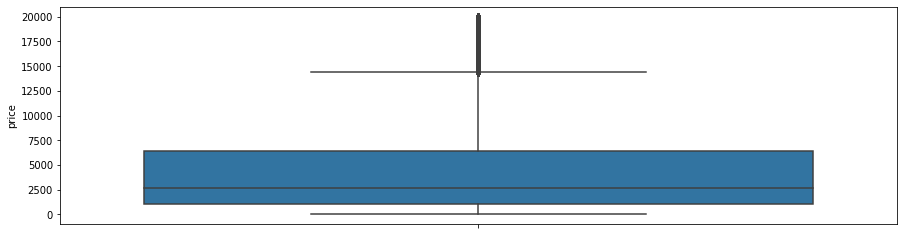

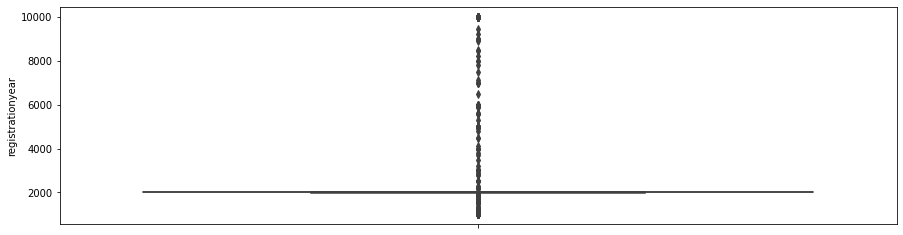

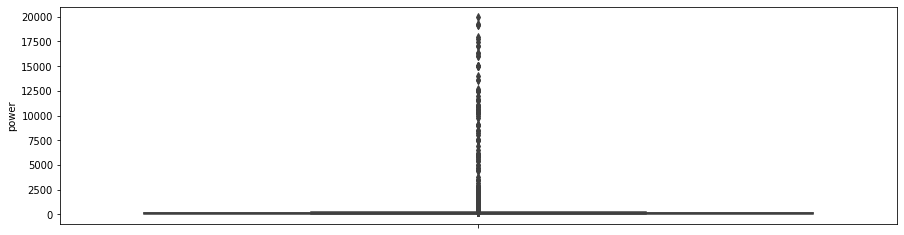

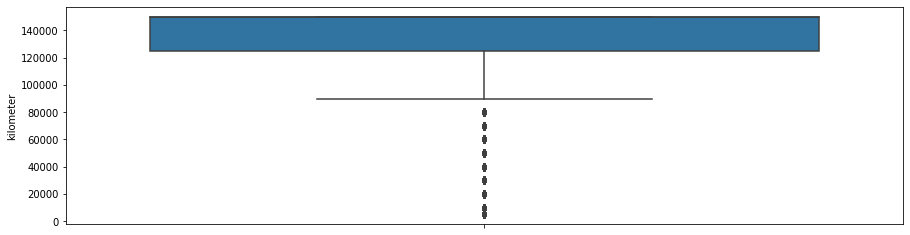

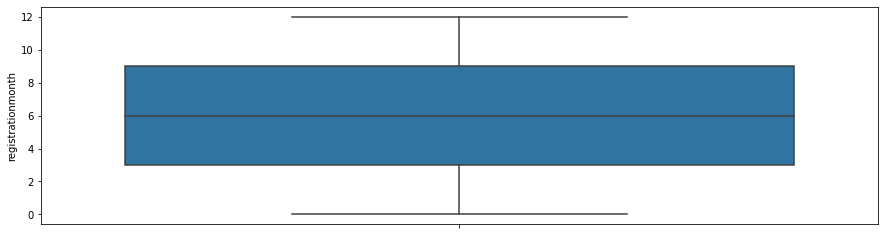

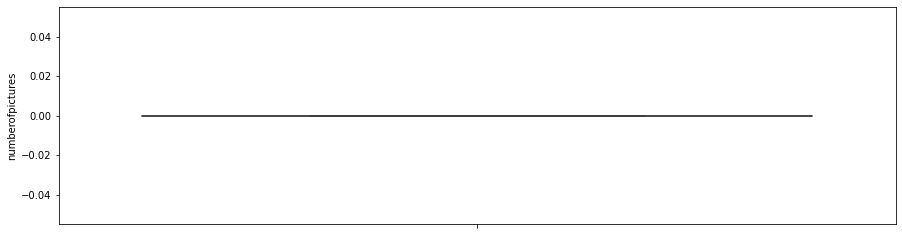

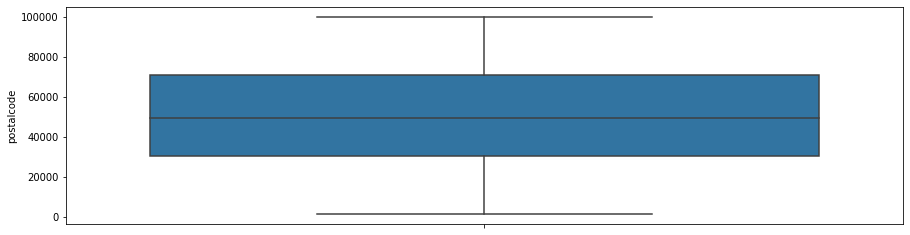

In [30]:
for i in numeric:
    plt.figure(figsize=(15, 4))
    sns.boxplot(y=i, data=df, orient="h")

Построим также гистограммы типа `int64`

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


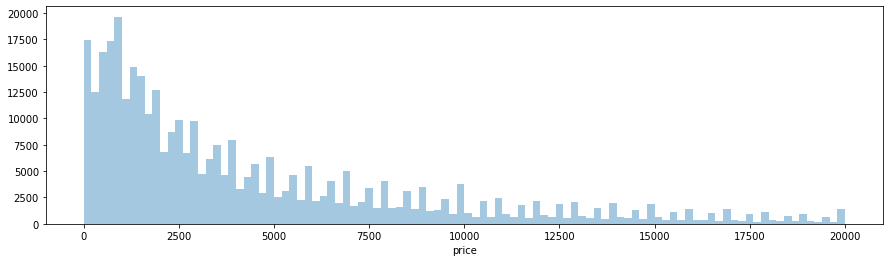

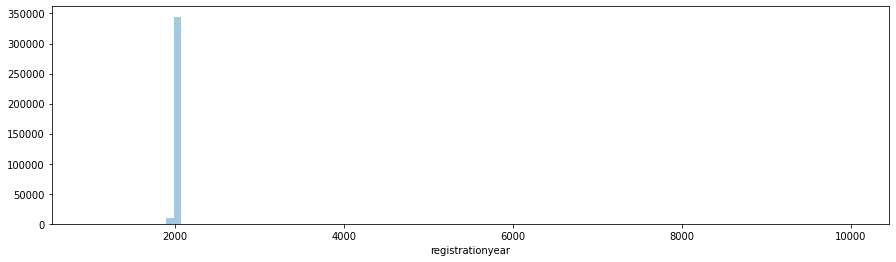

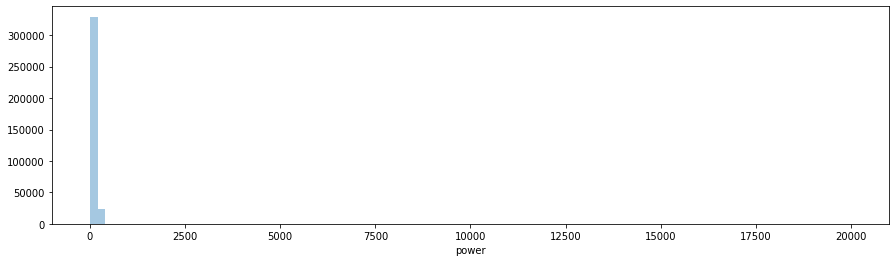

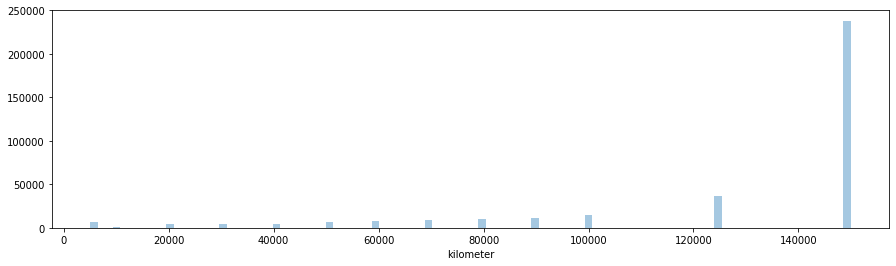

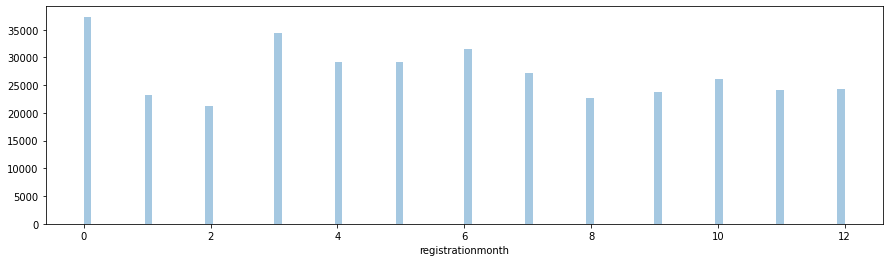

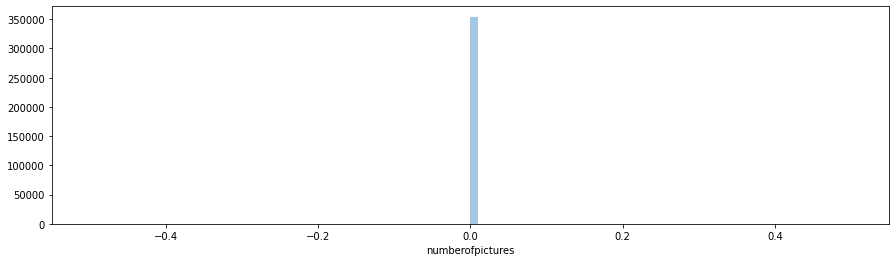

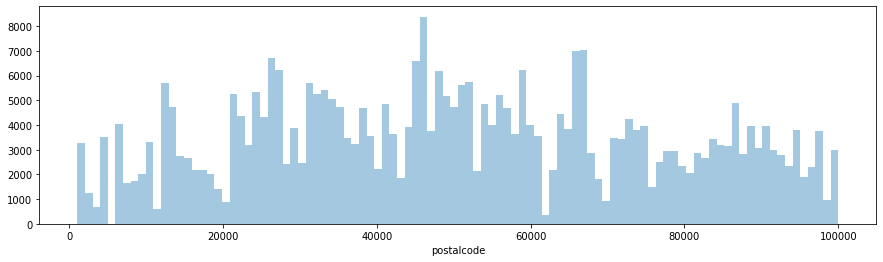

In [31]:
for i in numeric:
    plt.figure(figsize=(15, 4))
    sns.distplot(df[i], kde=False, bins=100)

Рассмотрим интересующие нас столбцы.

In [32]:
sorted(df['registrationyear'].unique())

[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

In [33]:
df['power'].describe()

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [34]:
df['price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

Из вышеприведённых данных видно, что имеются аномальные значения в столбцах `power`, `registrationyear`, `power`. К примеру имеются нулевыее и близкие к нулю значеия в столбцах `power`, `price`, в столбце `registrationyear` имеются вообще аномальные значения.

Найдём верхнюю границу выпуска автомобиля путём определения в столбце максимального значения.

In [35]:
print(df['datecreated'].max())

2016-04-07 00:00:00


In [36]:
print(df['datecreated'].dt.year.max())

2016


Удалим аномальные значения. Ограничим выборку между 1960 годом и 2016. Мощноть двигателей ограничим от 10 до 1000 лошадиных сил, Минимальная цена - 100 евро.

In [37]:
df = df.loc[(df['registrationyear'] < df['datecreated'].dt.year.max()) &
                (df['registrationyear'] > 1960) &
                (df['power'] < 1000) &
                (df['power'] > 10) &
                (df['price'] > 100)
               ]

Удалим ненужные столбцы для обучения моделей

In [38]:
df.drop(['datecrawled', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'], axis='columns', inplace=True)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288170 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              288170 non-null  int64 
 1   vehicletype        288170 non-null  object
 2   registrationyear   288170 non-null  int64 
 3   gearbox            288170 non-null  object
 4   power              288170 non-null  int64 
 5   model              288170 non-null  object
 6   kilometer          288170 non-null  int64 
 7   registrationmonth  288170 non-null  int64 
 8   fueltype           288170 non-null  object
 9   brand              288170 non-null  object
 10  repaired           288170 non-null  object
dtypes: int64(5), object(6)
memory usage: 26.4+ MB


In [40]:
display(df)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...,...
354359,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


**Вывод:**

Мы выгрузили даннные и подговоили их для обучения моделей.

Были пропуски в столбцах `vehicletype`, `Gearbox`, `model`, `fuelType` и `repaired`, а также некорректный тип данных в `datecrawled`, `datecreated` и `lastseen`.

* В `gearbox` и `repaired` пропуски заполнили `unknown`.
* В `model` заполнили пропуски `other`
* Для заполнения пропусков в `fueltype` и `vehicletype` использовали данные из других строк с тем же значением, что и в столбце `model`.
* Удалили ненужные столбцы для обучения моделей `datecrawled`, `datecreated`, `numberofpictures`, `postalcode`, `lastseen`.

# 2. Обучение моделей

Мы будем обучать модели ориентируясь на метрику RMSE. В качестве моделей мы буем использовать случйный лес, линейную регрессию, LGBMRegressor и CatboostRegressor. Закодируем категориальные признаки.

In [41]:
#data_ohe = pd.get_dummies(df, drop_first=True)
#del df

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288170 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              288170 non-null  int64 
 1   vehicletype        288170 non-null  object
 2   registrationyear   288170 non-null  int64 
 3   gearbox            288170 non-null  object
 4   power              288170 non-null  int64 
 5   model              288170 non-null  object
 6   kilometer          288170 non-null  int64 
 7   registrationmonth  288170 non-null  int64 
 8   fueltype           288170 non-null  object
 9   brand              288170 non-null  object
 10  repaired           288170 non-null  object
dtypes: int64(5), object(6)
memory usage: 26.4+ MB


In [43]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


**Разобъём выборки на обучающую (60%), валидационную (20%) и тестовую (20%)**

In [44]:
data_train, data_other_sample = train_test_split(df, test_size=0.4, random_state=12345) # отделяем обучающую выборку от остальной
data_valid, data_test = train_test_split(data_other_sample, test_size=0.5, random_state=12345) # делим остальную часть выборки на валидационную и тренировочную

In [45]:
print('Размер обучающей выборки', data_train.shape[0])
print('Размер валидационной выборки', data_valid.shape[0])
print('Размер тестовой выборки', data_test.shape[0])

Размер обучающей выборки 172902
Размер валидационной выборки 57634
Размер тестовой выборки 57634


In [46]:
features_train = data_train.drop(['price'], axis=1)
target_train = data_train['price']
features_valid = data_valid.drop(['price'], axis=1)
target_valid = data_valid['price']
features_test = data_test.drop(['price'], axis=1)
target_test = data_test['price']

In [47]:
#features = df.drop('price', axis=1)
#target = df['price']
#features_train, features_test, target_train, target_test = train_test_split(
#features, target, test_size=0.25, random_state=12345)

In [48]:
#encoder = OrdinalEncoder()
#encoder.fit(features_train)

In [49]:
BinEnc = ca.BinaryEncoder()

In [50]:
BinEnc.fit(features_train)

BinaryEncoder(cols=['vehicletype', 'gearbox', 'model', 'fueltype', 'brand',
                    'repaired'],
              mapping=[{'col': 'vehicletype',
                        'mapping':     vehicletype_0  vehicletype_1  vehicletype_2  vehicletype_3
 1              0              0              0              1
 2              0              0              1              0
 3              0              0              1              1
 4              0              1              0              0
 5              0              1              0              1
 6              0              1              1              0
 7              0              1              1              1
 8              1              0              0              0
-1              0              0              0              0
-2              0              0              0              0},
                       {'col': 'gearbox',
                        'mapping':     gearbox_0  gearbox_1
 1          0

In [51]:
features_train = BinEnc.transform(features_train)
features_test = BinEnc.transform(features_test)
features_valid = BinEnc.transform(features_valid)

In [52]:
print(features_train.shape)
print(features_test.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_test.shape)
print(target_valid.shape)

(172902, 30)
(57634, 30)
(57634, 30)
(172902,)
(57634,)
(57634,)


In [53]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

Также напишем функцию для расчёта метрики RMSE с помощью make_scorer

In [54]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

**Обучение линейной регрессии**

In [55]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
regression_cv_score = pd.Series(cross_val_score(model_lr, features_train, target_train, scoring=RMSE_score, cv=3)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации 2749.900555681623
CPU times: user 1.51 s, sys: 1.57 s, total: 3.09 s
Wall time: 3.07 s


**Обучение случайного леса**

In [56]:
%%time 

model_fr = RandomForestRegressor()
forest_parameters = {'n_estimators': range(5, 15, 5),
                    'max_depth': range(1, 6, 2),
                    'min_samples_leaf': range(1, 4),
                    'min_samples_split': range(2, 6, 2) }

forest_grid = GridSearchCV(model_fr, forest_parameters, scoring=RMSE_score, cv=3)
forest_grid.fit(features_train, target_train)

CPU times: user 1min 20s, sys: 321 ms, total: 1min 21s
Wall time: 1min 21s


GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 6, 2),
                         'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 6, 2),
                         'n_estimators': range(5, 15, 5)},
             scoring=make_scorer(RMSE, greater_is_better=False))

Определяем гиперпараметры и качество модели на кросс-валидации

In [57]:
forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_train, target_train) * (-1)

In [58]:
print(forest_params)

{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 5}


In [59]:
print(forest_score)

2299.6023975558223


**Обучаем ансамбль модели LGBMScore**

In [60]:
%%time

lg = lgb.LGBMRegressor()
lg_parameters = {'max_depth': [25, 50, 75],
                'learning_rate': [0.01, 0.1],
                'num_leaves': [500, 1200],
                'n_estimators': range(5, 15, 5)
                }

lg_grid = GridSearchCV(lg, lg_parameters, scoring=RMSE_score, cv=3)
lg_grid.fit(features_train, target_train)

CPU times: user 22min 28s, sys: 34.2 s, total: 23min 2s
Wall time: 23min 10s


GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [25, 50, 75],
                         'n_estimators': range(5, 15, 5),
                         'num_leaves': [500, 1200]},
             scoring=make_scorer(RMSE, greater_is_better=False))

Определяем гиперпараметры и качество модели на кросс-валидации

In [61]:
%%time

lg_params = lg_grid.best_params_
lg_score = lg_grid.score(features_train, target_train) * (-1)

CPU times: user 371 ms, sys: 0 ns, total: 371 ms
Wall time: 394 ms


In [62]:
print(lg_params)

{'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 10, 'num_leaves': 1200}


In [63]:
print(lg_score)

2189.0751936670513


**Обучаем модель CatBoostRegressor**

In [64]:
%%time

cbr = cb.CatBoostRegressor()

cb_parameters = {'iterations': [100],
                'depth': range(8, 16, 2),
                'learning_rate': [0.15]}

cb_grid = GridSearchCV(cbr, cb_parameters, scoring=RMSE_score, cv=3)
cb_grid.fit(features_train, target_train, verbose=10)

0:	learn: 4125.8356273	total: 80.3ms	remaining: 7.95s
10:	learn: 2186.1380441	total: 330ms	remaining: 2.67s
20:	learn: 1860.1455473	total: 575ms	remaining: 2.16s
30:	learn: 1767.4953558	total: 808ms	remaining: 1.8s
40:	learn: 1722.0670505	total: 1.04s	remaining: 1.5s
50:	learn: 1682.1929488	total: 1.27s	remaining: 1.22s
60:	learn: 1656.1809549	total: 1.51s	remaining: 967ms
70:	learn: 1630.3052536	total: 1.75s	remaining: 716ms
80:	learn: 1608.8330945	total: 2s	remaining: 468ms
90:	learn: 1594.9750214	total: 2.23s	remaining: 221ms
99:	learn: 1582.2768180	total: 2.44s	remaining: 0us
0:	learn: 4125.9990692	total: 42.3ms	remaining: 4.19s
10:	learn: 2163.6470795	total: 290ms	remaining: 2.34s
20:	learn: 1844.4287258	total: 537ms	remaining: 2.02s
30:	learn: 1753.2506824	total: 773ms	remaining: 1.72s
40:	learn: 1703.0195938	total: 1.02s	remaining: 1.47s
50:	learn: 1666.5945409	total: 1.28s	remaining: 1.23s
60:	learn: 1644.2651844	total: 1.6s	remaining: 1.02s
70:	learn: 1624.4065192	total: 1.84s

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f0b45b94e20>,
             param_grid={'depth': range(8, 16, 2), 'iterations': [100],
                         'learning_rate': [0.15]},
             scoring=make_scorer(RMSE, greater_is_better=False))

Определяем гиперпараметры и качество модели на кросс-валидации

In [65]:
%%time

cb_params = cb_grid.best_params_
cb_score = cb_grid.score(features_train, target_train) * (-1)

CPU times: user 179 ms, sys: 3.97 ms, total: 183 ms
Wall time: 186 ms


In [66]:
print(cb_params)

{'depth': 14, 'iterations': 100, 'learning_rate': 0.15}


In [67]:
print(cb_score)

1278.1963714442725


**Вывод:**

На данном этапе были обучены 4 модели, а именно - модель линейной регрессии, модель случайного леса, ансамбль моделей LGBMRegressor и CatboostRegressor. Также нами были определены оптимальные гиперпараметры и метрики RMSE для каждой модели на кросс-валидации.

# 3. Анализ моделей

Протестируем модели на тестовой выборке и проверим их на адекватность. Напишем функцию для важности признаков, которые будут показывать важность больше 0.0.

In [68]:
def feature_importance_hist(model, features_train):
    importances = list(model.feature_importances_)
    names_indices = features_train.columns
    not_null_importances = []
    not_null_indices = []

    for i in importances:
        if i>0:
            not_null_importances.append(i)
            not_null_indices.append(names_indices[importances.index(i)])
    
    plt.figure(figsize=(15, 10))
    plt.title("Feature importances")
 
    plt.bar(range(len(not_null_importances)), not_null_importances, color="g")
    plt.xticks(range(len(importances)), not_null_indices, rotation=90)
 
    plt.tight_layout()
    plt.xlim([-1, len(not_null_importances)])
    plt.show()

**Константная модель**

Создадим константную модель для проверки на адекватность

In [69]:
%%time

constant_model = pd.Series(target_valid.median(), index=target_valid.index)

#Определим метрику RMSE для константной модели
const_RMSE = round(RMSE(target_valid, constant_model), 3)
print('RMSE для констатной модели', const_RMSE)

RMSE для констатной модели 4925.799
CPU times: user 1.7 ms, sys: 2.99 ms, total: 4.69 ms
Wall time: 4.06 ms


**Модель линейной регресии**

In [70]:
%%time

regression_model = LinearRegression()
regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_valid)

regression_RMSE = round(RMSE(target_valid, regression_model_predictions), 3)
print('Модель линейной регрессии', regression_RMSE)

Модель линейной регрессии 2759.935
CPU times: user 422 ms, sys: 369 ms, total: 791 ms
Wall time: 790 ms


**Модель случайного леса**

In [71]:
%%time 

forest_model = RandomForestRegressor(random_state=12345,
                                     max_depth=forest_params['max_depth'],
                                     min_samples_leaf=forest_params['min_samples_leaf'],
                                     min_samples_split=forest_params['min_samples_split'],
                                     n_estimators=forest_params['n_estimators'])

forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_valid)

forest_RMSE = round(RMSE(target_valid, forest_model_predictions), 3)
print('RMSE модели случайного леса', forest_RMSE)

RMSE модели случайного леса 2303.182
CPU times: user 1.39 s, sys: 52.2 ms, total: 1.44 s
Wall time: 1.51 s


**Модель ансамбля решений LGBMRegressor**

In [72]:
%%time 

lg_model = lgb.LGBMRegressor(max_depth=lg_params['max_depth'],
                            learning_rate=lg_params['learning_rate'],
                            num_leaves=lg_params['num_leaves'],
                            n_estimators=lg_params['n_estimators'])

lg_model.fit(features_train, target_train)
lg_model_predictions = lg_model.predict(features_valid)

lg_RMSE = round(RMSE(target_valid, lg_model_predictions), 3)
print('RMSE модели LGBMRegressor:', lg_RMSE)

RMSE модели LGBMRegressor: 2275.482
CPU times: user 3min 49s, sys: 6.4 s, total: 3min 55s
Wall time: 3min 56s


**Модель ансамбля решений Catboost**

In [73]:
%%time

cb_model = cb.CatBoostRegressor(iterations=cb_params['iterations'],
                                learning_rate=cb_params['learning_rate'],
                                depth=cb_params['depth'])

cb_model.fit(features_train, target_train, verbose=10)
cb_model_predictions = cb_model.predict(features_valid)


cb_RMSE = round(RMSE(target_valid, cb_model_predictions), 3)
print('RMSE модели CatBoostRegressor:', cb_RMSE)

0:	learn: 4081.4947631	total: 664ms	remaining: 1m 5s
10:	learn: 1924.5527180	total: 7.17s	remaining: 58s
20:	learn: 1592.2570856	total: 14s	remaining: 52.6s
30:	learn: 1494.5006232	total: 20.5s	remaining: 45.7s
40:	learn: 1442.0302853	total: 27s	remaining: 38.9s
50:	learn: 1401.1679978	total: 33.6s	remaining: 32.3s
60:	learn: 1371.8336494	total: 40.6s	remaining: 26s
70:	learn: 1344.4193387	total: 47.4s	remaining: 19.3s
80:	learn: 1317.4455606	total: 54.1s	remaining: 12.7s
90:	learn: 1292.0415500	total: 1m	remaining: 6.01s
99:	learn: 1278.1963714	total: 1m 6s	remaining: 0us
RMSE модели CatBoostRegressor: 1536.55
CPU times: user 51.9 s, sys: 15 s, total: 1min 6s
Wall time: 1min 7s


**Таблица с результатами моделей**

In [74]:
columns = ['Модель', 'Время работы модели, сек.', 'RMSE']
constant_model = ['Константная модель', 0, const_RMSE]
model_lr = ['Модель линейной регрессии', 10, regression_RMSE]
forest_model = ['Модель случайного леса', 49, forest_RMSE]
lg_model = ['LGBMRegressor', 4, lg_RMSE]
cb_model = ['CatBoostRegressor', 64.0, cb_RMSE]

table = pd.DataFrame([constant_model, forest_model, model_lr, lg_model, lg_model, cb_model], columns = columns)
table['Качество по отношению к константной модели, %'] = round((1-table['RMSE']/const_RMSE) * 100, 2)

display(table)

,Модель,"Время работы модели, сек.",RMSE,"Качество по отношению к константной модели, %"
0,Константная модель,0.0,4925.799,0.00
1,Модель случайного леса,49.0,2303.182,53.24
2,Модель линейной регрессии,10.0,2759.935,43.97
3,LGBMRegressor,4.0,2275.482,53.80
4,LGBMRegressor,4.0,2275.482,53.80
5,CatBoostRegressor,64.0,1536.550,68.81


# Тестирование лучшей модели

In [77]:
%%time

cb_model = cb.CatBoostRegressor(iterations=cb_params['iterations'],
                                learning_rate=cb_params['learning_rate'],
                                depth=cb_params['depth'])

cb_model.fit(features_train, target_train, verbose=10)

test_model_catboost = cb_model.predict(features_test)
mse = mean_squared_error(target_test, test_model_catboost)
rmse = np.sqrt(mse)
print(f'RMSE на тестовом наборе: {rmse}')

0:	learn: 4081.4947631	total: 679ms	remaining: 1m 7s
10:	learn: 1924.5527180	total: 7.46s	remaining: 1m
20:	learn: 1592.2570856	total: 14.1s	remaining: 53.1s
30:	learn: 1494.5006232	total: 20.9s	remaining: 46.4s
40:	learn: 1442.0302853	total: 27.5s	remaining: 39.5s
50:	learn: 1401.1679978	total: 34s	remaining: 32.7s
60:	learn: 1371.8336494	total: 40.6s	remaining: 26s
70:	learn: 1344.4193387	total: 47s	remaining: 19.2s
80:	learn: 1317.4455606	total: 53.6s	remaining: 12.6s
90:	learn: 1292.0415500	total: 1m	remaining: 5.95s
99:	learn: 1278.1963714	total: 1m 6s	remaining: 0us
RMSE на тестовом наборе: 1543.3419006878996
CPU times: user 52.5 s, sys: 14.1 s, total: 1min 6s
Wall time: 1min 9s


Модель CatBoostRegtessor хорошо себя показала на тестовых данных, а именно RMSE = 1543.3, что соответствует условию задачи ниже порога 2500. Поэтому заказчику мы може рекомендовать в качестве оптимальной модели CatBoostRegressror.

# 4. Общий вывод

В ходе реализации проекта, нами были выполнены следующие задачи:

1) На первом этапе мы выгрузили данные и выявили в них пропуски, а также некорректные типы данных. Мы также занимались предоработкой данных, и подготавливали данные для обучения, где:
* Перевели названия столбцов в нижний регистр
* В `gearbox` и `repaired` пропуски заполнили `unknown`.
* В `model` заполнили пропуски `other`
* Для заполнения пропусков в `fueltype` и `vehicletype` использовали данные из других строк с тем же значением, что и в столбце `model`.
* Удалили ненужные столбцы для обучения моделей `datecrawled`, `datecreated`, `numberofpictures`, `postalcode`, `lastseen`.

2) На втором этапе были обучены 4 модели, а именно - модель линейной регрессии, модель случайного леса, ансамбль моделей LGBMRegressor и CatboostRegressor. Также нами были определены оптимальные гиперпараметры и метрики RMSE для каждой модели на кросс-валидации.

3) На третьем этапе мы занимались анализом моделей, в ходе которых мы определяли качество моделей относительно констатнной модели. RMSE для констатнной модели - 4938.143. Наименьший показатель RMSE был достигнут во время использования модели CatBoostRegressor и составил 4938.143.

В качестве рекомендованной модели можно предложить модель CatBoostRegressor.